In [1]:
!pip install ptflops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-10.3.10.19:
      Successfully uninstalled nvidia-curand-cu12-10.3.10.19
  Attemp

In [2]:
import pandas as pd
import numpy as np
import torch
import torchvision
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torchvision.io import read_image
from PIL import Image
import copy
import time
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from tqdm import tqdm
import seaborn as sns
from ptflops import get_model_complexity_info

In [3]:
learning_rate =1e-4
BATCH_SIZE = 32
epoch = 100
model_name = "EfficientNet_b0"

In [4]:
path = r"/kaggle/working/" + f"result_{model_name}"
if not os.path.exists(path):
    os.mkdir(path)

In [5]:
train_path= r"/kaggle/input/durian-leaf/A Durian Leaf/A Durian Leaf/A_Durian_Leaf_Image_Dataset/Durian_Leaf_Diseases/train"
val_path = r"/kaggle/input/durian-leaf/A Durian Leaf/A Durian Leaf/A_Durian_Leaf_Image_Dataset/Durian_Leaf_Diseases/val"
test_path= r"/kaggle/input/durian-leaf/A Durian Leaf/A Durian Leaf/A_Durian_Leaf_Image_Dataset/Durian_Leaf_Diseases/test"

mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

data_transform = {
    'Train': transforms.Compose([
        transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.LANCZOS),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
        transforms.RandomErasing(p=0.5, scale=(0.02, 0.2))  
    ]),
    "Validation": transforms.Compose([
        transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.LANCZOS),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'Test': transforms.Compose([
        transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.LANCZOS),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
}

train_dataset = datasets.ImageFolder(root=train_path, transform=data_transform["Train"])
val_dataset = datasets.ImageFolder(root=val_path, transform=data_transform["Validation"])
test_dataset = datasets.ImageFolder(root=test_path, transform=data_transform["Test"])

print("Classes:", train_dataset.classes)

print(f"Số lượng ảnh trong tập train: {len(train_dataset)}")
print(f"Số lượng ảnh trong tập val: {len(val_dataset)}")
print(f"Số lượng ảnh trong tập test: {len(test_dataset)}")

Classes: ['Leaf_Algal', 'Leaf_Blight', 'Leaf_Colletotrichum', 'Leaf_Healthy', 'Leaf_Phomopsis', 'Leaf_Rhizoctonia']
Số lượng ảnh trong tập train: 1814
Số lượng ảnh trong tập val: 387
Số lượng ảnh trong tập test: 394


In [6]:
train_loader = DataLoader(train_dataset, batch_size= BATCH_SIZE, shuffle= True)
val_loader = DataLoader(val_dataset, batch_size= BATCH_SIZE, shuffle= True)
test_loader = DataLoader(test_dataset, batch_size= BATCH_SIZE, shuffle= True)

data_loader= {"Train": train_loader,
                "Validation": val_loader}

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [8]:
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

num_features =model.classifier[1].in_features
model.classifier[1]= nn.Linear(num_features, 6)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 122MB/s] 


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [9]:
def train_model(data_loader, model, criterion, optimizer, num_epochs, device, early_stop= True, patience=10):
    model= model.to(device)
    model= torch.nn.DataParallel(model)

    since =time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_acc =0.0
    best_epoch = 0.0
    wait = 0

    history = {"Train_Loss":[],"Train_Acc":[],"Validation_Loss":[],"Validation_Acc":[],"Time":[]}

    result_current = {"Train_Loss": None,
                        "Train_Acc":None,
                        "Validition_Loss": None,
                        "Validition_ACC":None
                     }
    for epoch in range(num_epochs):
        
        print("-----------------------------------------------------------------------")
        print(f"Epoch {epoch+1}/{num_epochs}")
        epoch_start = time.time()
        
        for phase in ["Train", "Validation"]:
            if phase == "Train":
                model.train()
            else:
                model.eval()

            running_loss, running_correct = 0.0, 0
            total_samples = 0
            
            for images, labels in tqdm(data_loader[phase], desc="Training And Evaluation"):
                images = images.to(device)
                labels = labels.to(device)
                
                with torch.set_grad_enabled(phase=="Train"):
                    outputs = model(images)
                    _, predicts = torch.max(outputs, dim=1)
                    loss = criterion(outputs, labels)
                    
                    if phase == "Train":
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * images.size(0)
                running_correct += torch.sum(predicts == labels).item()
                total_samples += images.size(0)
                
            epoch_loss = running_loss / total_samples
            epoch_acc = running_correct / total_samples

            result_current[f"{phase}_Loss"] = epoch_loss
            result_current[f"{phase}_Acc"] = epoch_acc
            
            history[f"{phase}_Loss"].append(epoch_loss)
            history[f"{phase}_Acc"].append(epoch_acc)

            if phase == "Validation":
                if epoch_acc > best_val_acc:
                    best_val_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    best_epoch = epoch
                    wait = 0
                else:
                    wait += 1
        epoch_duration= time.time()- epoch_start
        history["Time"].append(epoch_duration)
        print(f"Train Loss: {result_current['Train_Loss']:.4f}, Train Acc: {result_current['Train_Acc']:.4f}")
        print(f"Valid Loss: {result_current['Validation_Loss']:.4f}, Valid Acc: {result_current['Validation_Acc']:.4f}")
        print(f"Epoch {epoch+1} finished in {epoch_duration:.2f}s")
    
        if early_stop and wait >= patience:
            print(f"Early stopping at epoch {epoch+1} (no improvement in {patience} epochs).")
            break
    
    print("-----------------------------------------------------------------------")
    time_elapse = time.time() - since
    print(f"Training Complete In {time_elapse}s")
    
    model.load_state_dict(best_model_wts)

    return model, pd.DataFrame(history), time_elapse, best_val_acc, best_epoch

In [10]:
model, history, time_elapse, best_val_acc, best_epoch = train_model(data_loader=data_loader, model=model, 
                                                                    criterion=criterion, optimizer=optimizer, 
                                                                    num_epochs=epoch, device=device, 
                                                                    early_stop=True, patience=10)

-----------------------------------------------------------------------
Epoch 1/100


Training And Evaluation: 100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


Train Loss: 1.4202, Train Acc: 0.5474
Valid Loss: 0.7494, Valid Acc: 0.7881
Epoch 1 finished in 48.97s
-----------------------------------------------------------------------
Epoch 2/100


Training And Evaluation: 100%|██████████| 13/13 [00:03<00:00,  3.45it/s]


Train Loss: 0.6529, Train Acc: 0.8170
Valid Loss: 0.3276, Valid Acc: 0.8863
Epoch 2 finished in 36.97s
-----------------------------------------------------------------------
Epoch 3/100


Training And Evaluation: 100%|██████████| 13/13 [00:03<00:00,  3.49it/s]


Train Loss: 0.3707, Train Acc: 0.8859
Valid Loss: 0.2364, Valid Acc: 0.9199
Epoch 3 finished in 37.36s
-----------------------------------------------------------------------
Epoch 4/100


Training And Evaluation: 100%|██████████| 13/13 [00:03<00:00,  3.48it/s]


Train Loss: 0.2715, Train Acc: 0.9129
Valid Loss: 0.1838, Valid Acc: 0.9380
Epoch 4 finished in 37.02s
-----------------------------------------------------------------------
Epoch 5/100


Training And Evaluation: 100%|██████████| 13/13 [00:03<00:00,  3.67it/s]


Train Loss: 0.2494, Train Acc: 0.9157
Valid Loss: 0.1747, Valid Acc: 0.9354
Epoch 5 finished in 36.46s
-----------------------------------------------------------------------
Epoch 6/100


Training And Evaluation: 100%|██████████| 13/13 [00:03<00:00,  3.60it/s]


Train Loss: 0.1982, Train Acc: 0.9316
Valid Loss: 0.1555, Valid Acc: 0.9509
Epoch 6 finished in 36.45s
-----------------------------------------------------------------------
Epoch 7/100


Training And Evaluation: 100%|██████████| 13/13 [00:03<00:00,  3.58it/s]


Train Loss: 0.1594, Train Acc: 0.9493
Valid Loss: 0.1485, Valid Acc: 0.9535
Epoch 7 finished in 37.36s
-----------------------------------------------------------------------
Epoch 8/100


Training And Evaluation: 100%|██████████| 13/13 [00:03<00:00,  3.45it/s]


Train Loss: 0.1442, Train Acc: 0.9526
Valid Loss: 0.1365, Valid Acc: 0.9587
Epoch 8 finished in 37.03s
-----------------------------------------------------------------------
Epoch 9/100


Training And Evaluation: 100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Train Loss: 0.1337, Train Acc: 0.9559
Valid Loss: 0.1407, Valid Acc: 0.9664
Epoch 9 finished in 36.66s
-----------------------------------------------------------------------
Epoch 10/100


Training And Evaluation: 100%|██████████| 13/13 [00:03<00:00,  3.70it/s]


Train Loss: 0.0942, Train Acc: 0.9691
Valid Loss: 0.1245, Valid Acc: 0.9638
Epoch 10 finished in 36.38s
-----------------------------------------------------------------------
Epoch 11/100


Training And Evaluation: 100%|██████████| 13/13 [00:03<00:00,  3.56it/s]


Train Loss: 0.0968, Train Acc: 0.9713
Valid Loss: 0.1280, Valid Acc: 0.9664
Epoch 11 finished in 36.35s
-----------------------------------------------------------------------
Epoch 12/100


Training And Evaluation: 100%|██████████| 13/13 [00:03<00:00,  3.47it/s]


Train Loss: 0.0879, Train Acc: 0.9768
Valid Loss: 0.1349, Valid Acc: 0.9690
Epoch 12 finished in 36.57s
-----------------------------------------------------------------------
Epoch 13/100


Training And Evaluation: 100%|██████████| 13/13 [00:03<00:00,  3.76it/s]


Train Loss: 0.0834, Train Acc: 0.9752
Valid Loss: 0.1214, Valid Acc: 0.9690
Epoch 13 finished in 36.09s
-----------------------------------------------------------------------
Epoch 14/100


Training And Evaluation: 100%|██████████| 13/13 [00:03<00:00,  3.58it/s]


Train Loss: 0.0726, Train Acc: 0.9752
Valid Loss: 0.1320, Valid Acc: 0.9612
Epoch 14 finished in 36.08s
-----------------------------------------------------------------------
Epoch 15/100


Training And Evaluation: 100%|██████████| 13/13 [00:03<00:00,  3.67it/s]


Train Loss: 0.0565, Train Acc: 0.9824
Valid Loss: 0.1229, Valid Acc: 0.9690
Epoch 15 finished in 36.12s
-----------------------------------------------------------------------
Epoch 16/100


Training And Evaluation: 100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Train Loss: 0.0631, Train Acc: 0.9785
Valid Loss: 0.1425, Valid Acc: 0.9664
Epoch 16 finished in 37.40s
-----------------------------------------------------------------------
Epoch 17/100


Training And Evaluation: 100%|██████████| 13/13 [00:03<00:00,  3.64it/s]


Train Loss: 0.0682, Train Acc: 0.9785
Valid Loss: 0.1216, Valid Acc: 0.9664
Epoch 17 finished in 35.74s
-----------------------------------------------------------------------
Epoch 18/100


Training And Evaluation: 100%|██████████| 13/13 [00:03<00:00,  3.61it/s]


Train Loss: 0.0398, Train Acc: 0.9895
Valid Loss: 0.1476, Valid Acc: 0.9690
Epoch 18 finished in 36.39s
-----------------------------------------------------------------------
Epoch 19/100


Training And Evaluation: 100%|██████████| 13/13 [00:03<00:00,  3.57it/s]


Train Loss: 0.0550, Train Acc: 0.9824
Valid Loss: 0.1331, Valid Acc: 0.9716
Epoch 19 finished in 36.62s
-----------------------------------------------------------------------
Epoch 20/100


Training And Evaluation: 100%|██████████| 13/13 [00:03<00:00,  3.68it/s]


Train Loss: 0.0482, Train Acc: 0.9857
Valid Loss: 0.1441, Valid Acc: 0.9638
Epoch 20 finished in 36.64s
-----------------------------------------------------------------------
Epoch 21/100


Training And Evaluation: 100%|██████████| 13/13 [00:03<00:00,  3.68it/s]


Train Loss: 0.0409, Train Acc: 0.9868
Valid Loss: 0.1327, Valid Acc: 0.9664
Epoch 21 finished in 36.35s
-----------------------------------------------------------------------
Epoch 22/100


Training And Evaluation: 100%|██████████| 13/13 [00:03<00:00,  3.56it/s]


Train Loss: 0.0451, Train Acc: 0.9846
Valid Loss: 0.1346, Valid Acc: 0.9664
Epoch 22 finished in 36.83s
-----------------------------------------------------------------------
Epoch 23/100


Training And Evaluation: 100%|██████████| 13/13 [00:03<00:00,  3.59it/s]


Train Loss: 0.0459, Train Acc: 0.9890
Valid Loss: 0.1422, Valid Acc: 0.9638
Epoch 23 finished in 36.69s
-----------------------------------------------------------------------
Epoch 24/100


Training And Evaluation: 100%|██████████| 13/13 [00:03<00:00,  3.63it/s]


Train Loss: 0.0469, Train Acc: 0.9879
Valid Loss: 0.1500, Valid Acc: 0.9612
Epoch 24 finished in 36.73s
-----------------------------------------------------------------------
Epoch 25/100


Training And Evaluation: 100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Train Loss: 0.0366, Train Acc: 0.9912
Valid Loss: 0.1496, Valid Acc: 0.9716
Epoch 25 finished in 36.74s
-----------------------------------------------------------------------
Epoch 26/100


Training And Evaluation: 100%|██████████| 13/13 [00:03<00:00,  3.68it/s]


Train Loss: 0.0426, Train Acc: 0.9868
Valid Loss: 0.1478, Valid Acc: 0.9638
Epoch 26 finished in 36.78s
-----------------------------------------------------------------------
Epoch 27/100


Training And Evaluation: 100%|██████████| 13/13 [00:03<00:00,  3.62it/s]


Train Loss: 0.0419, Train Acc: 0.9884
Valid Loss: 0.1916, Valid Acc: 0.9535
Epoch 27 finished in 36.52s
-----------------------------------------------------------------------
Epoch 28/100


Training And Evaluation: 100%|██████████| 13/13 [00:03<00:00,  3.57it/s]


Train Loss: 0.0250, Train Acc: 0.9939
Valid Loss: 0.1444, Valid Acc: 0.9664
Epoch 28 finished in 37.05s
-----------------------------------------------------------------------
Epoch 29/100


Training And Evaluation: 100%|██████████| 13/13 [00:03<00:00,  3.29it/s]

Train Loss: 0.0303, Train Acc: 0.9912
Valid Loss: 0.1565, Valid Acc: 0.9612
Epoch 29 finished in 37.12s
Early stopping at epoch 29 (no improvement in 10 epochs).
-----------------------------------------------------------------------
Training Complete In 1075.5131285190582s


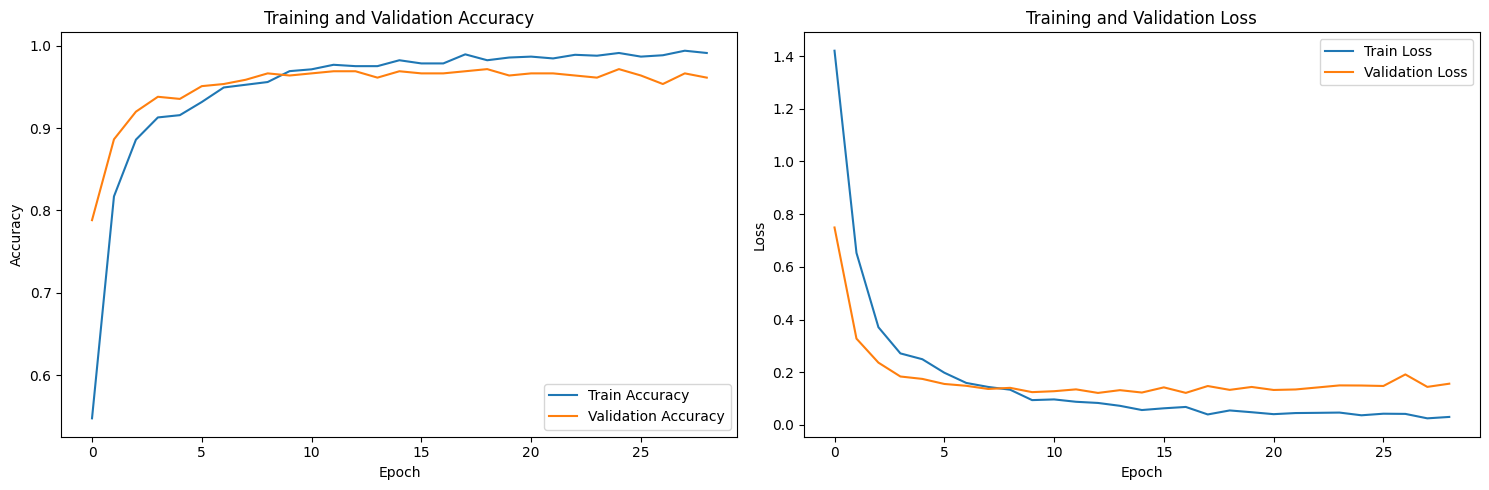

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(history['Train_Acc'], label='Train Accuracy')
axs[0].plot(history['Validation_Acc'], label='Validation Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].legend()

axs[1].plot(history['Train_Loss'], label='Train Loss')
axs[1].plot(history['Validation_Loss'], label='Validation Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].legend()

plt.tight_layout()
plt.savefig(os.path.join(path, "plot_loss_acc.png"))
plt.show()

Accuracy: 0.9593908629441624
Precision: 0.9598016888722278
Recall: 0.9593908629441624
F1-Score: 0.9589272225979159
                     precision    recall  f1-score   support

         Leaf_Algal     1.0000    0.9857    0.9928        70
        Leaf_Blight     0.9492    0.8485    0.8960        66
Leaf_Colletotrichum     0.9048    0.9500    0.9268        60
       Leaf_Healthy     0.9867    1.0000    0.9933        74
     Leaf_Phomopsis     0.9688    0.9841    0.9764        63
   Leaf_Rhizoctonia     0.9375    0.9836    0.9600        61

           accuracy                         0.9594       394
          macro avg     0.9578    0.9587    0.9576       394
       weighted avg     0.9598    0.9594    0.9589       394



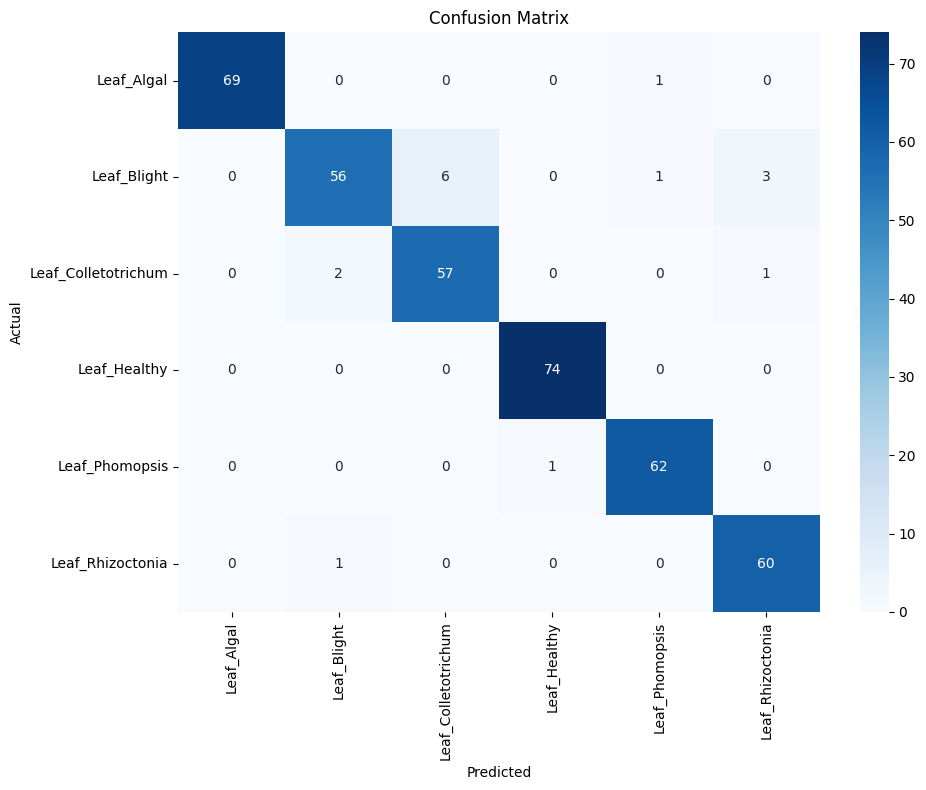

In [12]:
model.eval()

with torch.no_grad():
    
    all_correct = []
    all_predict = []
    
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicts = torch.max(outputs, dim=1)

        all_correct.extend(labels.cpu().numpy())
        all_predict.extend(predicts.cpu().numpy())

    acc = accuracy_score(all_correct, all_predict)
    precision = precision_score(all_correct, all_predict, average='weighted')
    recall = recall_score(all_correct, all_predict, average='weighted')
    f1 = f1_score(all_correct, all_predict, average='weighted')
    
    input_res = (3, 224, 224)
    flops, params = get_model_complexity_info(model, input_res, as_strings=True, print_per_layer_stat=False)
    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"Accuracy: {acc}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")

    result = {
        "Model": model_name,
        "Optimizer": "Adam",
        "Learning_Rate": learning_rate,
        "Batch_Size": BATCH_SIZE,
        "Num_Epoch": epoch,
        "Early_Stop": best_epoch,
        "Training_Time": time_elapse,
        "Best_Val_Acc": best_val_acc,
        "Accuracy": acc,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "FLOPs": flops,
        "Params": params,
        "Total_Params": total_params,
        "Trainable_Params": trainable_params,
             }
    
    result_df = pd.DataFrame([result])
    result_df.to_csv(os.path.join(path, "result.csv"), index=False)
    
    report = classification_report(all_correct, all_predict, target_names=train_dataset.classes, digits=4)
    print(report)
    with open(os.path.join(path, "classification_report.txt"), "w") as f:
        f.write(report)
        
    cm = confusion_matrix(all_correct, all_predict)
    
    # Hiển thị confusion matrix dưới dạng heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')

    plt.tight_layout()
    plt.savefig(os.path.join(path, 'confusion_matrix.png'))
    plt.show()
    
    plt.close()

In [13]:
torch.save(model.state_dict(), os.path.join(path, f'{model_name}_weights.pth'))
history.to_csv(os.path.join(path, "history.csv"), index=False)

In [14]:
import shutil

shutil.make_archive(path, 'zip', path)

'/kaggle/working/result_EfficientNet_b0.zip'